#### What is Parallelization in LangGraph?
In LangGraph, nodes typically execute in a sequence defined by edges, but when tasks don’t depend on each other’s outputs, you can run them in parallel. This is achieved by:
- Defining multiple nodes that can operate independently.

- Connecting them to a common starting point (e.g., START or another node).

- Merging their outputs into a downstream node if needed.

LangGraph handles this implicitly when nodes are independent and can leverage multi-threading or asynchronous execution under the hood, depending on the runtime environment (e.g., Python’s asyncio or a multi-threaded executor).

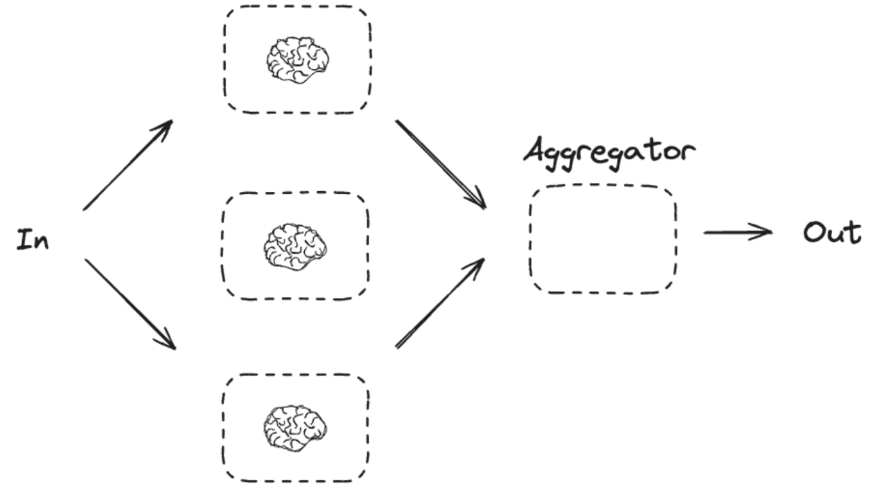

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen-qwq-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 30, 'total_tokens': 40, 'completion_time': 0.05, 'prompt_time': 0.003740605, 'queue_time': 0.052895384, 'total_time': 0.053740605}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_92412bc7e4', 'finish_reason': 'stop', 'logprobs': None}, id='run-efd39b04-a9fd-4143-824b-a9a453db99eb-0', usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40})

In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Graph state
class State(TypedDict):
    topic: str
    characters: str
    settings: str
    premises: str
    story_intro: str

In [3]:
# Nodes
def generate_characters(state: State):
    """Generate character descriptions"""
    msg = llm.invoke(f"Create two character names and brief traits for a story about {state['topic']}")
    return {"characters": msg.content}

def generate_setting(state: State):
    """Generate a story setting"""
    msg = llm.invoke(f"Describe a vivid setting for a story about {state['topic']}")
    return {"settings": msg.content}

def generate_premise(state: State):
    """Generate a story premise"""
    msg = llm.invoke(f"Write a one-sentence plot premise for a story about {state['topic']}")
    return {"premises": msg.content}

def combine_elements(state: State):
    """Combine characters, setting, and premise into an intro"""
    msg = llm.invoke(
        f"Write a short story introduction using these elements:\n"
        f"Characters: {state['characters']}\n"
        f"Setting: {state['settings']}\n"
        f"Premise: {state['premises']}"
    )
    return {"story_intro": msg.content}

In [4]:
# Build the graph
graph = StateGraph(State)
graph.add_node("character", generate_characters)
graph.add_node("setting", generate_setting)
graph.add_node("premise", generate_premise)
graph.add_node("combine", combine_elements)

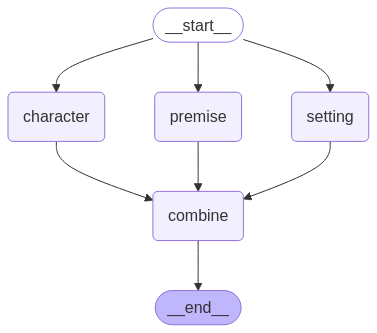

In [5]:
# Define edges (parallel execution from START)
graph.add_edge(START, "character")
graph.add_edge(START, "setting")
graph.add_edge(START, "premise")
graph.add_edge("character", "combine")
graph.add_edge("setting", "combine")
graph.add_edge("premise", "combine")
graph.add_edge("combine", END)

# Compile and run
compiled_graph = graph.compile()
graph_image = compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [6]:
state = {"topic": "time travel"}
result = compiled_graph.invoke(state)
print(result["story_intro"])

In the heart of a bustling, neon-lit metropolis, where the pulse of the future beats in synchrony with the rhythm of an ancient alleyway known as Time’s Passage, stands a curious library. This library, a labyrinth of time and knowledge, is the sanctuary of Evelyn "Eve" Turner, a historian with an encyclopedic mind and a heart brimming with curiosity for the past. Her companion is Jasper "Jax" Hawkins, an engineer of unparallelled skill and an adventurer at heart, who specializes in the mechanics of time travel devices. Together, they are about to embark on an adventure that will rewrite the very fabric of their reality.

The library, a quaint relic from the past, is a place where each book is a moment in history, and the air buzzes with the whispers of the past. At its center, under the watchful gaze of a rusted, weather-beaten clocktower, lies a peculiar device—a machine of brass and glass that can bend the fabric of reality. This is the Time Travel Device, the result of a bet between

#### Key Benefits
- Speed: Reduces total execution time by running tasks concurrently.

- Scalability: Handles larger workflows efficiently.

- Modularity: Keeps the graph structure clean and reusable.

#### Key Takeaways
- When to Parallelize: Use it for independent tasks (e.g., generating multiple outputs, checking separate inputs).

- Merging: Downstream nodes can aggregate parallel results.

- LangGraph Support: The framework naturally supports this by waiting for all required inputs before proceeding.

